# made some changes


1. [x] Introduction about the dynamic foraging task (Jeremiah just has half an hour lecture so maybe we need some explanation or some figures to explain the mechanism) [Shuchen]
2. [x] Introduction about generative model, [x] R-W rule [ ] winstayloseshift[Shuchen]
3. [x] Why and how to perform model simulation [Shuchen]
4. [x] How to perform model fitting and parameter recovery [Shuchen]
5. [] make things more coherent, check what else would be needed
6. [] getting more parameter recovery plots, to make the process more intuitive?


# The dynamic foraging task:

From a fly to a primate, every creature needs to get to know its environment, search for resources, and make choices about their behavior. The ability of foraging is prosessed across a range of model systems.

The dynamic foraging task is a simple paradigm to study this behavior. In the task, a head-fixed mouse waits to hears a go-cue that signals the opportunity to exerts two possible actions - licking left, or licking right. 

Unbeknownst to the animal, there is the probability of getting a water reward (P(reward)) for licking left, and licking right, varies over time. 

# the goal of model fitting:

By fitting models to experimental data we can probe the algorithms underlying behavior, find neural correlates of computational variables.
goal: use precise mathematical models to make better sense of behavioral data

The behavioral data most often come in the form of choices, but can also be reaction times, eye movements, or other easily observable behaviors, and even neural data. The models come in the form of mathematical equations that link the experimentally observable variables (e.g. stimuli, outcomes, past experiences) to behavior in the immediate future. In this sense, *computational models instantiate different ‘algorithmic hypotheses’ about how behavior is generated*.


## Simulation
Simulation involves running the model with particular parameter settings to generate ‘fake’ behavioral data. These simulated data can then be analyzed in much the same way as one would analyze real data, to make precise, falsifiable predictions about qualitative and quantitative patterns. Simulation makes theoretical predictions more precise and testable. (Some examples include Cohen et al., 1990; Collins and Frank, 2014; Rescorla and Wagner, 1972; Farashahi et al., 2017; Montague et al., 1996; Abbott et al., 2015; Lee and Webb, 2005).


## Parameter estimation
Parameter estimation involves finding the set of parameter values that best account for real behavioral data of a model. These parameters can be used as a succinct summary of a given data set (Ratcliff, 1978; Wilson et al., 2013; Daw et al., 2011; Donkin et al., 2016), for investigating individual differences (Frank et al., 2007; Starns and Ratcliff, 2010; Collins and Frank, 2012; Gillan et al., 2016; Somerville et al., 2017; Nilsson et al., 2011) and for quantifying the effects of interventions such as drugs, lesions, illness, or experimental conditions (Frank et al., 2004; Lorains et al., 2014; Dowd et al., 2016; Zajkowski et al., 2017; Warren et al., 2017; Wimmer et al., 2018; van Ravenzwaaij et al., 2011).


## Model comparison
Model comparison involves trying to compute which of a set of possible models best describes the behavioral data, as a way to understand which mechanisms are more likely to underlie behavior. This is especially useful when the different models make similar qualitative predictions but differ quantitatively (Wilson and Niv, 2011; Daw et al., 2011; Collins and Frank, 2012; Collins and Frank, 2012; Fischer and Ullsperger, 2013; Steyvers et al., 2009; Haaf and Rouder, 2017; Donkin et al., 2014).


##  Q learning

We quantified learning using Q-learning, a reinforcement-learning model that estimates the values of
alternative actions and learns from errors in expected action outcomes (RPE; Figure 1d; Bertsekas and
Tsitsiklis, 1996; Sutton and Barto, 1998). The model provides an estimate of RPE on single trials (Figures
1e and A1).

## Model 1: Rescorla Wagner 

In this model, participants first learn the expected value of each action based on the history of previous outcomes and then use these values to make a decision about what to do next. A simple model of learning is the Rescorla-Wagner learning rule (Rescorla and Wagner, 1972), whereby the value of option $k$, $Q^k_t$ is updated in response to reward $r_t$ according to:

$$Q^k_{t+1}=Q^k_t+\alpha(r_t−Q^k_t)$$

where $\alpha$ is the learning rate, which takes a value between 0 and 1 and captures the extent to which the prediction error, $(r_t−Q^k_t)$, updates the value. For simplicity, the initial value, $Q^k_0$ is often assumed to be zero, or treated as a free parameter of the model.


Assume that participants use the options’ values to guide their decisions, A simple model of decision making is to choose the most valuable option most frequently, but occasionally making ‘mistakes’ (or exploring) by choosing a low-value option. One choice rule with these properties is known as the ‘softmax’ choice rule, which chooses option $k$ with probability

$$p^k_t=\frac{exp(\beta Q^k_t)}{\sum_{i=1}^k exp(\beta Q^i_t)}$$

where $\beta$ is the ‘inverse temperature’ parameter that controls the level of stochasticity in the choice, ranging from $\beta=0$ for completely random responding and $\beta=∞$ for deterministically choosing the highest value option.

Combining the learning (Equation 3) and decision rules (Equation 4) gives a simple model of decision-making in this task with two free parameters: the learning rate, α, and the inverse temperature, β. That is, in our general notation, for this model 𝜽3=(α,β).





Once you have an experimental design and a set of computational models, a really important step is to create fake, or surrogate data (Palminteri et al., 2017). That is, you should use the models to simulate the behavior of participants in the experiment, and to observe how behavior changes with different models, different model parameters, and different variants of the experiment. This step will allow you to refine the first two steps: confirming that the experimental design elicits the behaviors assumed to be captured by the computational model. To do this, here are some important steps.



# Simulation and parameter recovery of dynamic foraging task.


In [1]:
# change the task to uncoupled 
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from aind_behavior_gym.dynamic_foraging.task import UncoupledBlockTask
from utils_model_recovery import *


# Create a task environment


In [2]:
# df[["agent_class_name", "preset_name", "n_free_params", "params"]]

# # Create the task environment
task = UncoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

# initialize an agent

In [3]:
# "Rescorla-Wagner": dict(
#     description="The vanilla Rescorla-Wagner model disccused in the Sutton & Barto book",
#     agent_class="ForagerQLearning",
#     agent_kwargs=dict(
#         number_of_learning_rate=1,
#         number_of_forget_rate=0,
#         choice_kernel="none",
#         action_selection="epsilon-greedy",
#     ),


forager = ForagerQLearning(number_of_learning_rate=1,number_of_forget_rate=0,choice_kernel="none",action_selection="epsilon-greedy")


In [4]:
task

# Simulate the task 

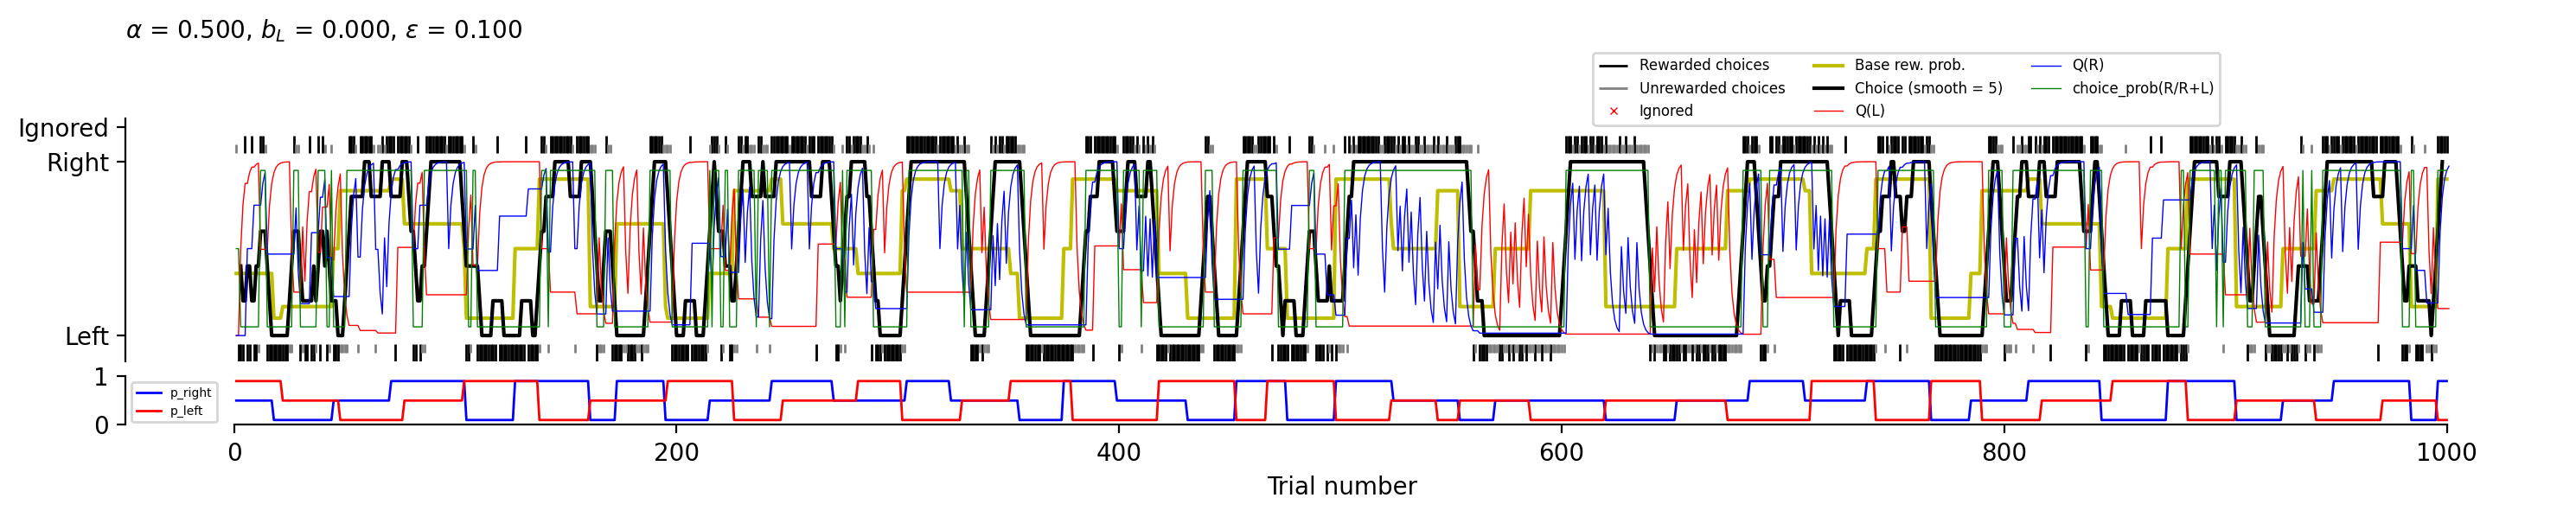

In [5]:

# Run the model
forager.perform(task)

# Capture the results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value
# Get the history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot the session results
fig, axes = forager.plot_session(if_plot_latent=True)

# Parameter Recovery


In [6]:
forager.fit(
    choice_history,
    reward_history,
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

2025-07-10 02:12:10,528 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 196.92093061081988
differential_evolution step 2: f(x)= 196.92093061081988
differential_evolution step 3: f(x)= 196.88115628813222
differential_evolution step 4: f(x)= 196.88115628813222
differential_evolution step 5: f(x)= 196.86399172987618
differential_evolution step 6: f(x)= 196.86399172987618
differential_evolution step 7: f(x)= 196.8490312203998
Polishing solution with 'L-BFGS-B'


In [7]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate', 'epsilon']
Ground truth: ['0.5000', '0.1000']
Fitted:       ['0.5753', '0.0982']
Likelihood-Per-Trial: 0.8213171724162133
Prediction accuracy full dataset: 0.95



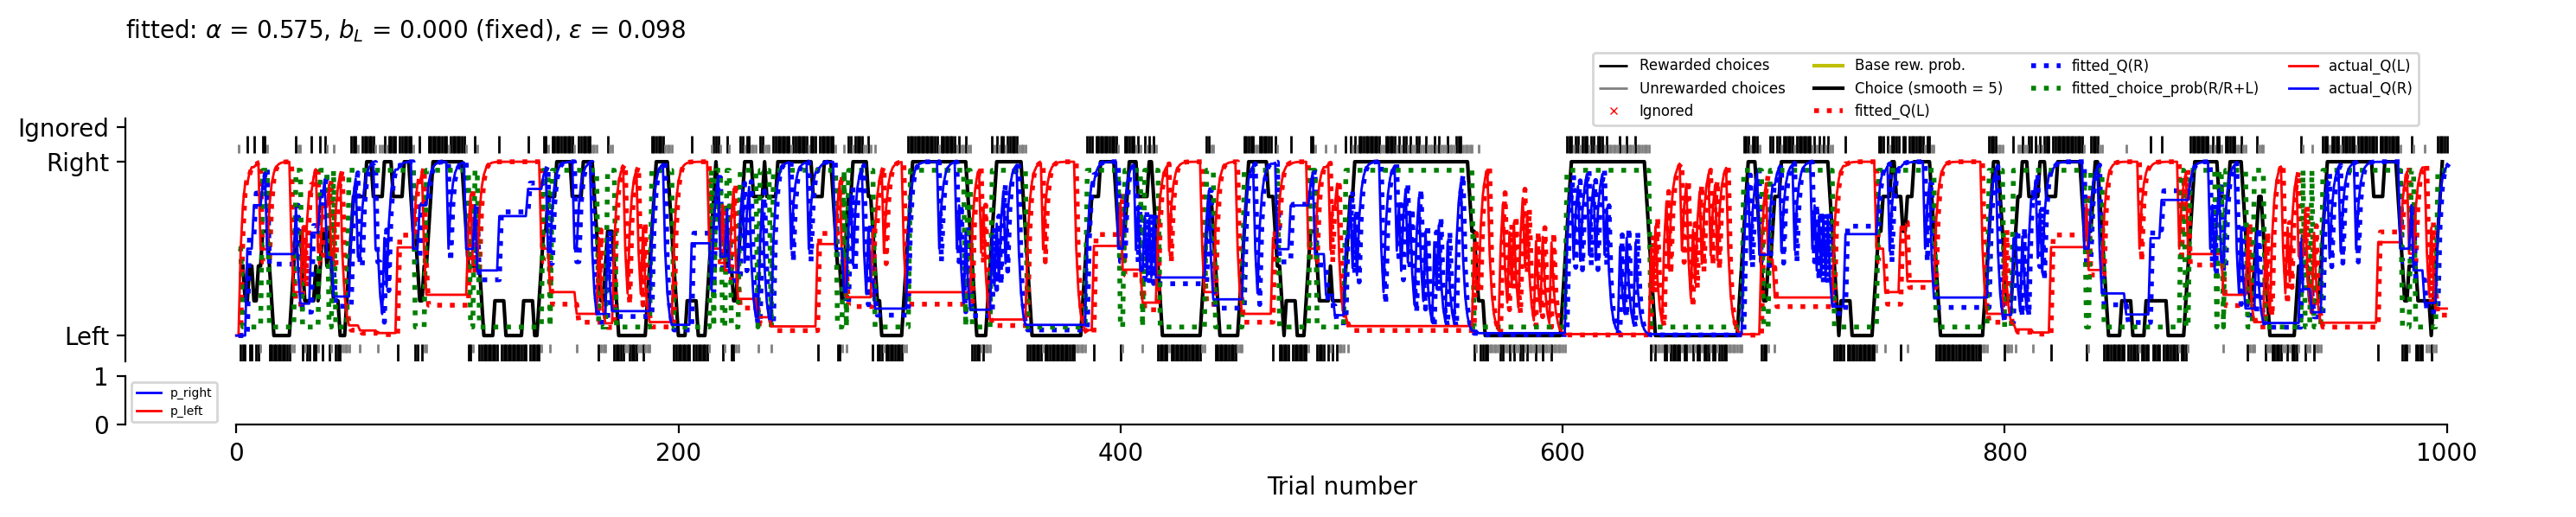

In [8]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay the ground truth Q-values for comparison
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

# Model: Noisy win-stay-lose-shift


The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions.


 In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1−\epsilon$, and chooses randomly with probability $\epsilon$. In the two-bandit case, the probability of choosing option k is
Let \( c_t \in \{1, 2\} \) be the choice at trial \( t \), and \( r_t \in \{0, 1\} \) the reward at trial \( t \). Then:

$$
p_k^t = 
\begin{cases}
1 - \frac{\epsilon}{2} & \text{if } (c_{t-1} = k \land r_{t-1} = 1) \text{ or } (c_{t-1} \neq  k \land r_{t-1} = 0) \\
\frac{\epsilon}{2} & \text{if } (c_{t-1} \not = k \land r_{t-1} = 1) \text{ or } (c_{t-1} = k \land r_{t-1} = 0)
\end{cases}
$$

Although more complex to implement, this model still only has one free parameter, the overall level of randomness, \( \theta_2 = \epsilon \).

In [11]:
# #         "Win-Stay-Lose-Shift": dict(
#             description="The vanilla Win-stay-lose-shift model",
#             agent_class="ForagerLossCounting",
#             agent_kwargs=dict(
#                 win_stay_lose_switch=True,
#                 choice_kernel="none",
#             ),


forager = ForagerLossCounting(win_stay_lose_switch=True, choice_kernel='none')

# Initialize the model
# forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
# forager.set_params(
#     softmax_inverse_temperature=5,
#     biasL=0,
# )

# Create the task environment
# task = CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

In [13]:
# Run the model
forager.perform(task)

# Capture the results
ground_truth_params = forager.params.model_dump()
ground_truth_loss_count_threshold_mean = forager.loss_count_threshold_mean
ground_truth_loss_count_threshold_std = forager.loss_count_threshold_std

# Get the history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot the session results
fig, axes = forager.plot_session(if_plot_latent=True)

AttributeError: 'ForagerLossCounting' object has no attribute 'loss_count_threshold_mean'

In [ ]:
# Fit the model to recover parameters
forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
forager.fit(
    choice_history,
    reward_history,
    fit_bounds_override={"softmax_inverse_temperature": [0, 100]},
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager.fitting_result

In [ ]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")
Num of trials: 1000

In [ ]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay the ground truth Q-values for comparison
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)